<a href="https://colab.research.google.com/github/Pipe-Runner/reinforcement-learning-experiments/blob/master/q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Installations

In [166]:
!pip install -r https://raw.githubusercontent.com/huggingface/deep-rl-class/main/notebooks/unit2/requirements-unit2.txt --quiet

!sudo apt-get -qq update
!apt install -qq python-opengl ffmpeg xvfb
!pip3 install pyvirtualdisplay --quiet

python-opengl is already the newest version (3.1.0+dfsg-2build1).
ffmpeg is already the newest version (7:4.2.7-0ubuntu0.1).
xvfb is already the newest version (2:1.20.13-1ubuntu1~20.04.8).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


## Imports

In [167]:
import os
from pyvirtualdisplay import Display
from IPython import display
import time

import numpy as np
import gymnasium as gym
import random
import imageio
import os
import tqdm

import pickle5 as pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Start Virtual Screen

In [168]:
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

## Utils

In [169]:
def show_video(env, Qtable, seed=None):
    plt.ion()

    images = []
    terminated = False
    truncated = False
    state, info = env.reset()
    img = plt.imshow(env.render())

    while True:
        img.set_data(env.render()) 
        display.display(plt.gcf())
        plt.axis('off')
        time.sleep(1)
        display.clear_output(wait=True)

        if terminated or truncated:
          print(reward)
          break

        action = np.argmax(Qtable[state])
        state, reward, terminated, truncated, info = env.step(
            action
        ) 

# Q-Learning (Frozen Lake v1 - Slippery )

## Create Env 

In [165]:
env = gym.make("FrozenLake-v1", map_name="4x4", is_slippery=True, render_mode="rgb_array")

print("_____OBSERVATION SPACE_____ \n")
print("Observation Space", env.observation_space)
print("Sample observation", env.observation_space.sample())

print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape", env.action_space.n)
print("Action Space Sample", env.action_space.sample())

_____OBSERVATION SPACE_____ 

Observation Space Discrete(16)
Sample observation 8

 _____ACTION SPACE_____ 

Action Space Shape 4
Action Space Sample 0


## Creating Q-Table

In [193]:
state_space = env.observation_space.n
action_space = env.action_space.n

def initialize_q_table(state_space, action_space):
    Qtable = np.zeros((state_space, action_space))
    return Qtable

Qtable_frozenlake = initialize_q_table(state_space, action_space)

## Defining policy

In [194]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state])

  return action

def epsilon_greedy_policy(Qtable, state, epsilon):
  if np.random.random() > epsilon:
    # exploit
    return greedy_policy(Qtable, state)
  else:
    # explore
    return env.action_space.sample()

## Hyperparams

In [196]:
# Training parameters
n_training_episodes = 10000  # Total training episodes
learning_rate = 0.9  # Learning rate

# # Evaluation parameters
n_eval_episodes = 100  # Total number of test episodes

# # Environment parameters
env_id = "FrozenLake-v1"  # Name of the environment
max_steps = 99  # Max steps per episode
gamma = 0.96  # Discounting rate
eval_seed = []  # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0  # Exploration probability at start
min_epsilon = 0.005  # Minimum exploration probability
decay_rate = 0.0005  # Exponential decay rate for exploration prob

## Eval

In [197]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed = None):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        step = 0
        truncated = False
        terminated = False
        total_rewards_ep = 0

        for step in range(max_steps):
            # Take the action (index) that have the maximum expected future reward given that state
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward

            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    return mean_reward, std_reward

## Training

In [198]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  eval_metrics = {
      "episode": [],
      "mean_reward": [],
      "std_reward": []
  }
  
  for episode_idx in tqdm(range(n_training_episodes)):
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode_idx)

    state, info = env.reset()
    
    step = 0
    terminated = False
    truncated = False

    for step in range(max_steps):
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      new_state, reward, terminated, truncated, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] += learning_rate * ((reward + gamma * np.max(Qtable[new_state])) - Qtable[state][action])

      if terminated or truncated:
        break

      # Our next state is the new state
      state = new_state

    if episode_idx % 50 == 0:
      mean_reward, std_reward = evaluate_agent(
          env, max_steps, 
          n_eval_episodes, 
          Qtable_frozenlake
      )

      eval_metrics["episode"].append(episode_idx)
      eval_metrics["mean_reward"].append(mean_reward)
      eval_metrics["std_reward"].append(std_reward)

  return Qtable, eval_metrics

## Agent Training

In [199]:
Qtable_frozenlake, eval_metrics = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/10000 [00:00<?, ?it/s]

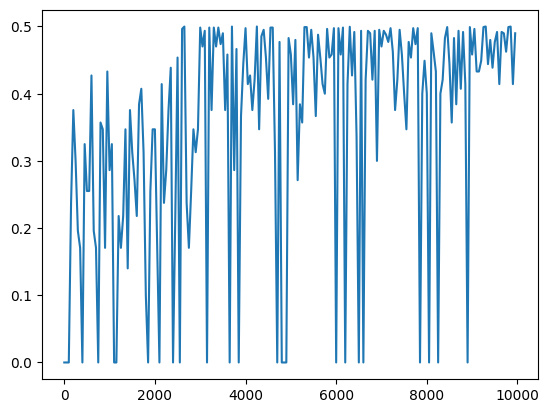

In [203]:
plt.plot(eval_metrics["episode"], eval_metrics["mean_reward"])
 
# function to show the plot
plt.show()

In [201]:
Qtable_frozenlake

array([[4.95099319e-01, 2.77820334e-01, 7.56305347e-02, 7.90737577e-02],
       [2.05357043e-03, 4.12436487e-03, 1.14816644e-03, 2.71573319e-01],
       [1.65727557e-03, 3.35040960e-03, 3.56269922e-02, 1.81772099e-01],
       [2.41197517e-03, 9.36451801e-04, 1.58877583e-03, 6.56573823e-02],
       [3.89485464e-01, 2.14774620e-01, 4.11908483e-02, 5.08935198e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.21916534e-06, 6.97763917e-07, 2.56463069e-02, 3.78413648e-10],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.57459411e-02, 5.11770550e-03, 2.70332436e-02, 3.09678373e-01],
       [5.74850844e-03, 7.55212252e-01, 4.34319221e-06, 4.62757010e-02],
       [9.49831718e-01, 4.99305649e-04, 8.73584225e-03, 1.27551186e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.28127931e-03, 7.59372149e-02, 8.29466929e

1.0


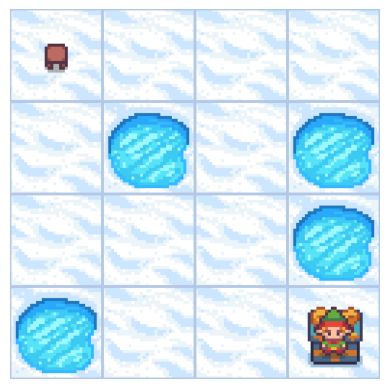

In [202]:
show_video(env, Qtable_frozenlake)